# OpAmp filter circuits
Last update: 2 Sept 2022  

Todo:
- ~~fix size of displayed schematics~~
- ~~look at new examples, what types work or don't work~~
- expand and clean up narative 
- make this notebook the main report
- write abstract and intro for the blog
- ~~re-simulate circuits in LTspice for final plots~~
- Verify net lists and schematics
- spell check

This notebook examines operational amplifiers ([opamp](https://en.wikipedia.org/wiki/Operational_amplifier)) used in two filter circuits. 
Nodal equations for the networks were generated from the net list exported from LTspice and then symbolic and numerical solutions are obtained from the circuit netlist. SciPy libraries are used to plot filter [impulse response](https://en.wikipedia.org/wiki/Impulse_response), [step response](https://en.wikipedia.org/wiki/Step_response), [Bode plot](https://en.wikipedia.org/wiki/Bode_plot) and [group delay](https://en.wikipedia.org/wiki/Group_delay_and_phase_delay) of the filters. The filter circuits examined employ an opamp model that requires a DC path from the output terminal to the negative input terminal of the opamp. No error checking is provided and if the condition is violated, the results will be likely erroneous. 

For small circuits with a handful of components, symbolic solutions of the node equations can be of interest and compared to examples given in college textbooks. By starting with a circuit drawn with a schematic capture program like LTspice, the netlist can be generated automatically eliminating setup errors. Then with the python code discussed [here](https://github.com/Tiburonboy/Symbolic-modified-nodal-analysis), the node equations can be generated automatically, which can then be solved with either SymPy or SciPy. The kinds of circuit analysis problems that electrical engineering students are asked to do as homework become very easy with a little bit of python code. 

# OpAmp filter circuits blog post
Last update: 11 May 2022  

This blog post summarizes the results from my Jupyter notebook, which can be viewed [here]().

The Jupyter notebook examines operational amplifiers ([OpAmp](https://en.wikipedia.org/wiki/Operational_amplifier)) used in two filter circuits. Numeric and symbolic solutions are obtained for the voltages and currents in the circuits. For small circuits with a handful of components, symbolic solutions of the node equations can be of interest and compared to examples given in college textbooks. By starting with a circuit drawn with a schematic capture program like LTspice, the netlist can be generated automatically eliminating setup errors. Then with the python code discussed [here](https://github.com/Tiburonboy/Symbolic-modified-nodal-analysis), the node equations can be generated automatically, which can then be solved with either SymPy or SciPy. The kinds of circuit analysis problems that electrical engineering students are asked to do as homework become very easy with some Python code. 

SciPy libraries are used to plot filter [impulse response](https://en.wikipedia.org/wiki/Impulse_response), [step response](https://en.wikipedia.org/wiki/Step_response), [Bode plot](https://en.wikipedia.org/wiki/Bode_plot) and [group delay](https://en.wikipedia.org/wiki/Group_delay_and_phase_delay) of the filters. 

The first circuit is a Sallen–Key low pass filter. This circuit shown below is a 3rd order low pass filter using three resistors, three capacitors and one opamp.

The second circuit, show below, is a two stage RIAA phono preamplifier. RIAA equalization is a specification for the recording and playback of phonograph records, established by the Recording Industry Association of America (RIAA). 

The JupyterLab notebook is located on github, click [here](https://github.com/Tiburonboy/EE_jupyter_notebooks/tree/main/OpAmp%20Filters) to follow the link to the repository.

In [30]:
import numpy as np
from sympy import *
from scipy import signal
import matplotlib.pyplot as plt
init_printing()

## OpAmp filter circuit 1
This circuit shown below is a 3rd order low pass filter using three resistors, three capacitors and one opamp and was obtained from [1]. The filter is a [Sallen–Key](https://en.wikipedia.org/wiki/Sallen%E2%80%93Key_topology) type filter with capacitance values of 0.1uF and a cut off of 1000Hz. 

<img src="opamp_filter_circuit_1.png" width="750">  

The Sallen–Key topology is an electronic filter topology used to implement second-order active filters that is particularly valued for its simplicity. Additional information about Sallen–Key can be found in [2].

The schematic of the filter was entered into LTspice and the netlist obtained:
```
V1 1 0 AC 1
R1 1 2 22.65k
R2 2 3 22.65k
R3 3 4 22.65k
R4 5 0 1k
C1 2 0 6940p
C2 3 5 0.01µ
C3 0 4 1783p
O 4 5 5 * LTspice opamp lines replaced
*XU1 4 5 N002 N001 5 LT1037
*Vneg1 0 N001 15
*Vpos1 N002 0 15
```
The netlist was edited to remove the opamp power connections and the values of the components were converted to exponential notation with units of Ohms, Farads and Henerys. The edited netlist is: 
~~~
* OpAmp circuit 1
V1 1 0 1
R1 1 2 22.65e3
R2 2 3 22.65e3
R3 3 4 22.65e3
R4 5 0 1e3
C1 2 0 6940e-12
C2 3 5 0.01e-6
C3 0 4 1783e-12
O 4 5 5
~~~

From the netlist above, the MNA [code](https://github.com/Tiburonboy/Symbolic-modified-nodal-analysis) generated the following network equations:
```
[[Eq(I_V1 + v1/R1 - v2/R1, 0)],
[Eq(v2*(C1*s + 1/R2 + 1/R1) - v3/R2 - v1/R1, 0)],
[Eq(-C2*s*v5 + v3*(C2*s + 1/R3 + 1/R2) - v4/R3 - v2/R2, 0)],
[Eq(v4*(C3*s + 1/R3) - v3/R3, 0)],
[Eq(-C2*s*v3 + I_O + v5*(C2*s + 1/R4), 0)],
[Eq(v1, V1)],
[Eq(v4 - v5, 0)]]
```

The following symbols and equations are initialized for the SymPy environment.

In [31]:
# declare the following symbols
v3, V1, C3, v1, v5, C1, I_O, R1, R4, R3, s, v2, v4, I_V1, R2, C2 = symbols('v3 V1 C3 v1 v5 C1 I_O R1 R4 R3 s v2 v4 I_V1 R2 C2')

# use the equations generated by nodal analysis
equ = Matrix(
    [[Eq(I_V1 + v1/R1 - v2/R1, 0)],
    [Eq(v2*(C1*s + 1/R2 + 1/R1) - v3/R2 - v1/R1, 0)],
    [Eq(-C2*s*v5 + v3*(C2*s + 1/R3 + 1/R2) - v4/R3 - v2/R2, 0)],
    [Eq(v4*(C3*s + 1/R3) - v3/R3, 0)],
    [Eq(-C2*s*v3 + I_O + v5*(C2*s + 1/R4), 0)],
    [Eq(v1, V1)],
    [Eq(v4 - v5, 0)]])
equ

⎡                    v₁   v₂                 ⎤
⎢             I_V1 + ── - ── = 0             ⎥
⎢                    R₁   R₁                 ⎥
⎢                                            ⎥
⎢        ⎛       1    1 ⎞   v₃   v₁          ⎥
⎢     v₂⋅⎜C₁⋅s + ── + ──⎟ - ── - ── = 0      ⎥
⎢        ⎝       R₂   R₁⎠   R₂   R₁          ⎥
⎢                                            ⎥
⎢              ⎛       1    1 ⎞   v₄   v₂    ⎥
⎢-C₂⋅s⋅v₅ + v₃⋅⎜C₂⋅s + ── + ──⎟ - ── - ── = 0⎥
⎢              ⎝       R₃   R₂⎠   R₃   R₂    ⎥
⎢                                            ⎥
⎢             ⎛       1 ⎞   v₃               ⎥
⎢          v₄⋅⎜C₃⋅s + ──⎟ - ── = 0           ⎥
⎢             ⎝       R₃⎠   R₃               ⎥
⎢                                            ⎥
⎢                        ⎛       1 ⎞         ⎥
⎢    -C₂⋅s⋅v₃ + I_O + v₅⋅⎜C₂⋅s + ──⎟ = 0     ⎥
⎢                        ⎝       R₄⎠         ⎥
⎢                                            ⎥
⎢                  v₁ = V₁                   ⎥
⎢            

Find the symbolic solution.

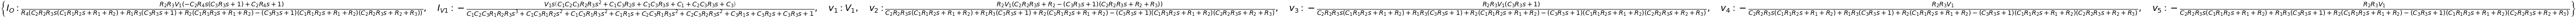

In [32]:
# find symbolic solution
u = solve(equ,[v1, v2, v3, v4, v5, I_V1, I_O])
u # display the results

The network system function is the output voltage at node 5, divided by the input voltage, V1.

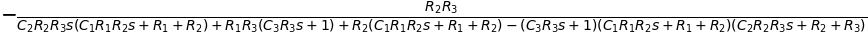

In [33]:
H = u[v5]/V1 # system function
H # display the system function

In [34]:
num, denom = fraction(H) #returns numerator and denominator

The following SymPy code collects and expands the system equation around s.

In [35]:
collect((denom/num).expand(),s)

The results above are the same as in [1].

The element values are entered into the equations so that a numerical solution can be obtained.

In [36]:
# find a numerical solution, substitute the element values
equ = equ.subs({R1:22.65e3,R2:22.65e3,R3:22.65e3,R4:1e3,C1:6940e-12,C2:0.01e-6,C3:1783e-12})
equ  # display the equations

⎡                       I_V1 + 4.41501103752759e-5⋅v₁ - 4.41501103752759e-5⋅v₂
⎢                                                                             
⎢      -4.41501103752759e-5⋅v₁ + v₂⋅(6.94e-9⋅s + 8.83002207505519e-5) - 4.4150
⎢                                                                             
⎢-1.0e-8⋅s⋅v₅ - 4.41501103752759e-5⋅v₂ + v₃⋅(1.0e-8⋅s + 8.83002207505519e-5) -
⎢                                                                             
⎢                  -4.41501103752759e-5⋅v₃ + v₄⋅(1.783e-9⋅s + 4.41501103752759
⎢                                                                             
⎢                             I_O - 1.0e-8⋅s⋅v₃ + v₅⋅(1.0e-8⋅s + 0.001) = 0   
⎢                                                                             
⎢                                                v₁ = V₁                      
⎢                                                                             
⎣                                              v₄ - 

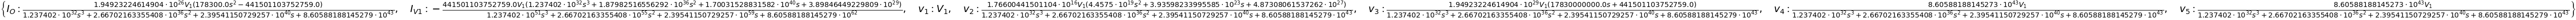

In [37]:
# solve for the unknowns
u1 = solve(equ,[v1, v2, v3, v4, v5, I_V1, I_O])
u1

Notice that the values of the exponents are very large in the solution. The numerator and denominator for v5 could be divided by 1e43. Another option for avoiding large exponents is to 1st normalize the component values by frequency scaling. I suppose that large exponents don't become a problem as long as they remain under two digits.

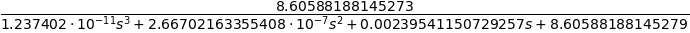

In [38]:
num, denom = fraction(u1[v5])
(num/1e43)/(denom/1e43)/V1

Almost all platforms map Python floats to the IEEE754 double precision - 64 total bits. The float information using the sys package can be as shown as follows:

In [39]:
import sys
sys.float_info

sys.float_info(max=1.7976931348623157e+308, max_exp=1024, max_10_exp=308, min=2.2250738585072014e-308, min_exp=-1021, min_10_exp=-307, dig=15, mant_dig=53, epsilon=2.220446049250313e-16, radix=2, rounds=1)

Letting SciPy do the math and not worrying about the size of the exponents. The system transfer function, is $H(s) = \frac {v5}{V1}$

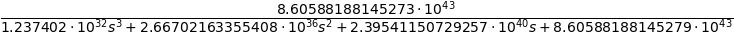

In [40]:
H = u1[v5]/V1
H

Extract the numerator and denominator polynomials so that the system can be defined in SciPy.

In [41]:
num, denom = fraction(H) #returns numerator and denominator

# convert symbolic to numpy polynomial
a = np.array(Poly(num, s).all_coeffs(), dtype=float)
b = np.array(Poly(denom, s).all_coeffs(), dtype=float)
system_c1 = (a, b) # system for circuit 1

### Plot the impulse and step response
Use the SciPy functions [impulse2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.impulse2.html) and [step2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.step2.html) to plot the impulse and step response of the system.

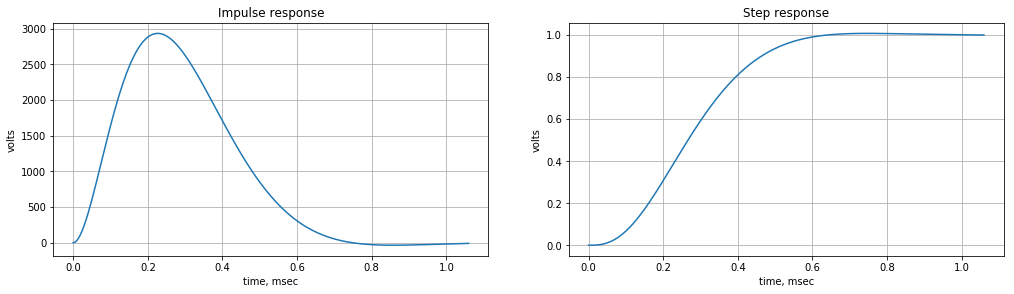

In [42]:
plt.subplots(figsize=(15, 5))

# using subplot function and creating
# plot one
plt.subplot(1, 2, 1)

# impulse response
t, y = signal.impulse2(system_c1,N=500)
plt.plot(t/1e-3, y)
plt.title('Impulse response')
plt.ylabel('volts')
plt.xlabel('time, msec')
plt.grid()

# using subplot function and creating plot two
plt.subplot(1, 2, 2)

t, y = signal.step2(system_c1,N=500)
plt.plot(t/1e-3, y)
plt.title('Step response')
plt.ylabel('volts')
plt.xlabel('time, msec')
plt.grid()

# space between the plots
plt.tight_layout(4)

# show plot
plt.show()

The [impulse](https://en.wikipedia.org/wiki/Impulse_response) and [step response](https://en.wikipedia.org/wiki/Step_response) of the filter are plotted above. Any linear, time-invariant is completely characterized by its impulse response. The transfer function is the Laplace transform of the impulse response. The impulse response defines the response of a linear time-invariant system for all frequencies.

In practical systems, it is not possible to produce a perfect impulse to serve as input for testing; therefore, a brief pulse is sometimes used as an approximation of an impulse. Provided that the pulse is short enough compared to the impulse response, the result will be close to the true, theoretical, impulse response.

In electronic engineering and control theory, step response is the time behavior of the outputs of a general system when its inputs change from zero to one in a very short time.

### Plot the Bode magnitude and phase data
Use the SciPy function [bode](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.bode.html) to plot the magnitude and phase of the filter.

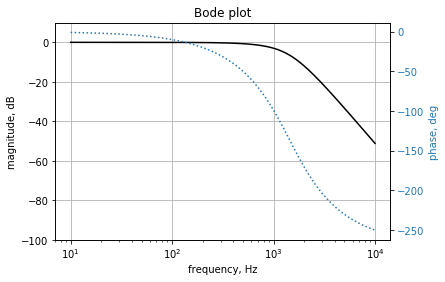

In [43]:
x = np.linspace(10*2*np.pi, 10e3*2*np.pi, 1000, endpoint=True)
w, mag, phase = signal.bode(system_c1, w=x)

fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

#plt.semilogx(w, mag)    # Bode magnitude plot
#plt.plot(w/(2*np.pi*1e6), mag,'-k')    # Bode magnitude plot
#plt.plot(w/(2*np.pi), mag,'-k')    # Bode magnitude plot
plt.semilogx(w/(2*np.pi), mag,'-k')    # Bode magnitude plot

ax1.tick_params(axis='y')
ax1.set_ylim((-100,10))
#ax1.set_xlim((27e6*2*np.pi,33e6*2*np.pi))
#ax1.set_xlim((27,33))
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'

#plt.semilogx(w, phase,'-g')  # Bode phase plot
#plt.plot(w/(2*np.pi), phase,':',color=color)  # Bode phase plot
plt.semilogx(w/(2*np.pi), phase,':',color=color)  # Bode phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim((-5,25))

plt.title('Bode plot')
plt.show()

In electrical engineering, a [Bode plot](https://en.wikipedia.org/wiki/Bode_plot) is a graph of the frequency response of a system. It is usually a combination of the magnitude (usually in decibels) of the frequency response and the phase shift. As originally conceived by Hendrik Wade Bode in the 1930s, the plot is an asymptotic approximation of the frequency response, using straight line segments. Bode plots are used to assess the stability of systems by finding the gain and phase margins.

In [44]:
# Find neasest position in the array where the value is located
def find_nearest(array,value):
    idx,val = min(enumerate(array), key=lambda x: abs(x[1]-value))
    return idx

In [45]:
# gain margin
print('gain margin = {:.2f} dB'.format(mag[find_nearest(phase, -180)]))

gain margin = -13.94 dB


In [46]:
# phase margin
print('phase margin = {:.2f} deg'.format(phase[find_nearest(mag, -0.1 )] - (-180)))

phase margin = 160.96 deg


#### Plot the group delay.
The following python code calculates and plots [group delay](https://en.wikipedia.org/wiki/Group_delay_and_phase_delay#). Frequency components of a signal are delayed when passed through a circuit and the signal delay will be different for the various frequencies unless the circuit has the property of being linear phase. The delay variation means that signals consisting of multiple frequency components will suffer distortion because these components are not delayed by the same amount of time at the output of the device.

Group delay: $\tau _{g}(\omega )=-\frac  {d\phi (\omega )}{d\omega }$

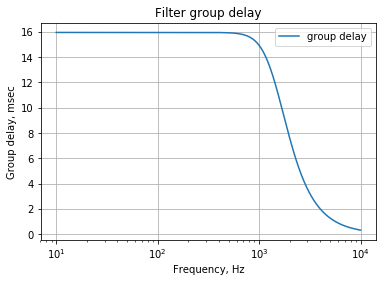

In [47]:
plt.title('Filter group delay')
plt.semilogx(w/(2*np.pi), -np.gradient(phase)/np.gradient(w)/1e-3,'-',label='group delay')
#plt.semilogx(w/(2*np.pi), -np.gradient(phase)/w/1e-3,'-',label='phase delay')
plt.ylabel('Group delay, msec')
plt.xlabel('Frequency, Hz')
plt.legend()
plt.grid()
plt.show()

The results obtained from the python code do not agree with LTspice. LTspice shows the group delay at 100Hz to be -278.4us, the plot above shows 16msec at about 100Hz. LTspice gives the phase at -10.5 deg at 100Hz, the bode plot above shows about -10 degrees. This difference needs to be explored.

## OpAmp circuit 2, RIAA Equalizer
[RIAA equalization](https://en.wikipedia.org/wiki/RIAA_equalization) is a specification for the recording and playback of phonograph records, established by the Recording Industry Association of America (RIAA). The purposes of the equalization are to permit greater recording times (by decreasing the mean width of each groove), to improve sound quality, and to reduce the groove damage that would otherwise arise during playback.

RIAA equalization is a form of pre-emphasis on recording and de-emphasis on playback. A recording is made with the low frequencies reduced and the high frequencies boosted, and on playback, the opposite occurs. The net result is a flat frequency response, but with attenuation of high-frequency noise such as hiss and clicks that arise from the recording medium. Reducing the low frequencies also limits the excursions the cutter needs to make when cutting a groove. Groove width is thus reduced, allowing more grooves to fit into a given surface area, permitting longer recording times. This also reduces physical stresses on the stylus, which might otherwise cause distortion or groove damage during playback.

RIAA playback equalization is not a simple low-pass filter. It defines transition points in three places: 75 μs, 318 μs and 3180 μs, which correspond to 2122 Hz, 500 Hz and 50 Hz. The pre-emphasis transfer function is expressed as follows, where T1=3180 μs, T2=318 μs, etc.:

$f(s)=\frac {(sT_{1}+1)(sT_{3}+1)}{(sT_{2}+1)}$

The following two Stage RIAA Phono Preamplifier is from [3].

<img src="Two_amplifier_RIAA_Phone_Preamp.png" width="750">  

The input is shunted by a capacitance equal to the sum of the input cable capacitance and Cs. This capacitance resonates with the inductance of the moving magnet cartridge around 15 kHz to 20 kHz to determine the frequency response of the transducer, so when a moving magnet pickup is used, Cs should be carefully chosen so that the total capacitance is equal to the recommended load capitance for that particular cartridge.

The first operational amplifier takes care of the 50 Hz and 500 Hz breakpoints, while the 2122 Hz rolloff is accomplished by the passive network R3 , R6 , and C4 . The second amplifier supplies additional gain, 10 dB in this example. Using two amplifiers results in accurate conformance to the RIAA curve without reverting to the noisy inverting topology, as well as lower distortion due to the fact that each amplifier is operating at a lower gain than would be the case in a single-amplifier design.

The schematic of the filter was entered into LTspice and the netlist obtained:
~~~
* Two amplifier RIAA Phone Preamp
V1 1 0 AC .018
C1 2 4 0.039µ
C2 3 0 200µ
R21 2 3 499
R3 5 6 2.3k
R1 2 4 80.6k
R2 4 5 8.45k
Vneg1 0 VEE 15
Vpos1 VCC 0 15
Cs 1 0 100p
R20 1 0 47k
XU2 1 2 VCC VEE 5 LT1007
XU3 7 8 VCC VEE 9 LT1007
C4 6 0 0.033µ
C5 7 6 2µ
R6 7 0 54.9k
R4 8 0 2k
R5 9 8 4.3k
R22 9 0 10k
;op
.ac dec 100 10 50000
;tran 500m
.lib LTC.lib
.backanno
.end
~~~

The netlist was edited to remove the opamp power connections and the values of the components were converted to exponential notation with units of Ohms, Farads and Henerys. The edited netlist is: 
~~~
* Two amplifier RIAA Phone Preamp
V1 1 0 0.018
C1 2 4 0.039e-6
C2 3 0 200e-6
R21 2 3 499
R3 5 6 2.3e3
R1 2 4 80.6e3
R2 4 5 8.45e3
Cs 1 0 100e-12
R20 1 0 47e3
O2 1 2 5
O3 7 8 9
C4 6 0 0.033e-6
C5 7 6 2e-6
R6 7 0 54.9e3
R4 8 0 2e3
R5 9 8 4.3e3
R22 9 0 10e3
~~~

From the netlist above, the MNA [code](https://github.com/Tiburonboy/Symbolic-modified-nodal-analysis) generated the following network equations:
~~~
[[Eq(I_V1 + v1*(Cs*s + 1/R20), 0)],
[Eq(v2*(C1*s + 1/R21 + 1/R1) + v4*(-C1*s - 1/R1) - v3/R21, 0)],
[Eq(v3*(C2*s + 1/R21) - v2/R21, 0)], [Eq(v2*(-C1*s - 1/R1) + v4*(C1*s + 1/R2 + 1/R1) - v5/R2, 0)],
[Eq(I_O2 + v5*(1/R3 + 1/R2) - v6/R3 - v4/R2, 0)],
[Eq(-C5*s*v7 + v6*(C4*s + C5*s + 1/R3) - v5/R3, 0)],
[Eq(-C5*s*v6 + v7*(C5*s + 1/R6), 0)],
[Eq(v8*(1/R5 + 1/R4) - v9/R5, 0)],
[Eq(I_O3 + v9*(1/R5 + 1/R22) - v8/R5, 0)],
[Eq(v1, V1)],
[Eq(v1 - v2, 0)],
[Eq(v7 - v8, 0)]]
~~~

The following symbols and equations are initialized for the SymPy environment.

In [48]:
# declare the following symbols
Cs, s, v8, R1, C2, R22, R2, v9, I_O3, R3, R21, C4, v6, V1, C1, I_V1, R5, v4, I_O2, v1, v7, R20, v3, v5, C5, R4, v2, R6 = symbols(
    'Cs s v8 R1 C2 R22 R2 v9 I_O3 R3 R21 C4 v6 V1 C1 I_V1 R5 v4 I_O2 v1 v7 R20 v3 v5 C5 R4 v2 R6')

# use the equations generated by nodal analysis
equ = Matrix(
    [[Eq(I_V1 + v1*(Cs*s + 1/R20), 0)],
    [Eq(v2*(C1*s + 1/R21 + 1/R1) + v4*(-C1*s - 1/R1) - v3/R21, 0)],
    [Eq(v3*(C2*s + 1/R21) - v2/R21, 0)], [Eq(v2*(-C1*s - 1/R1) + v4*(C1*s + 1/R2 + 1/R1) - v5/R2, 0)],
    [Eq(I_O2 + v5*(1/R3 + 1/R2) - v6/R3 - v4/R2, 0)],
    [Eq(-C5*s*v7 + v6*(C4*s + C5*s + 1/R3) - v5/R3, 0)],
    [Eq(-C5*s*v6 + v7*(C5*s + 1/R6), 0)],
    [Eq(v8*(1/R5 + 1/R4) - v9/R5, 0)],
    [Eq(I_O3 + v9*(1/R5 + 1/R22) - v8/R5, 0)],
    [Eq(v1, V1)],
    [Eq(v1 - v2, 0)],
    [Eq(v7 - v8, 0)]])
equ

⎡                     ⎛        1 ⎞               ⎤
⎢           I_V1 + v₁⋅⎜Cs⋅s + ───⎟ = 0           ⎥
⎢                     ⎝       R₂₀⎠               ⎥
⎢                                                ⎥
⎢   ⎛        1    1 ⎞      ⎛        1 ⎞    v₃    ⎥
⎢v₂⋅⎜C₁⋅s + ─── + ──⎟ + v₄⋅⎜-C₁⋅s - ──⎟ - ─── = 0⎥
⎢   ⎝       R₂₁   R₁⎠      ⎝        R₁⎠   R₂₁    ⎥
⎢                                                ⎥
⎢              ⎛        1 ⎞    v₂                ⎥
⎢           v₃⋅⎜C₂⋅s + ───⎟ - ─── = 0            ⎥
⎢              ⎝       R₂₁⎠   R₂₁                ⎥
⎢                                                ⎥
⎢    ⎛        1 ⎞      ⎛       1    1 ⎞   v₅     ⎥
⎢ v₂⋅⎜-C₁⋅s - ──⎟ + v₄⋅⎜C₁⋅s + ── + ──⎟ - ── = 0 ⎥
⎢    ⎝        R₁⎠      ⎝       R₂   R₁⎠   R₂     ⎥
⎢                                                ⎥
⎢                 ⎛1    1 ⎞   v₆   v₄            ⎥
⎢       I_O2 + v₅⋅⎜── + ──⎟ - ── - ── = 0        ⎥
⎢                 ⎝R₃   R₂⎠   R₃   R₂            ⎥
⎢                              

Find the symbolic solution.

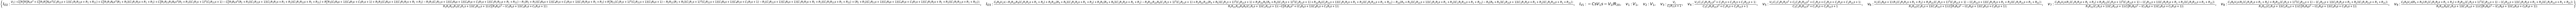

In [49]:
# find symbolic solution
u = solve(equ,[v1, v2, v3, v4, v5, v6, v7, v8, v9, I_V1, I_O2, I_O3])
u # display the results

The symbolic solution obtained by SymPy, while not being very interesting since they are unweildly, they illustrate the power of SymPy to easily obtain symbolic solutions that would be very difficult to obtain by hand. 

The network system function is the output voltage at node 9.

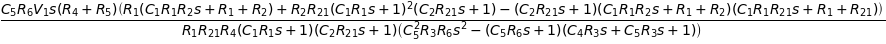

In [50]:
H = u[v9] # system function
H # display the system function

In [51]:
num, denom = fraction(H) #returns numerator and denominator

The following SymPy code collects and expands the system equation around s.

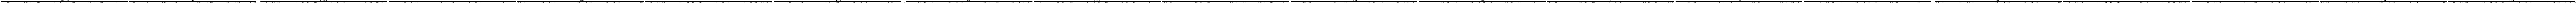

In [52]:
collect((denom/num).expand(),s)

The results above are don't seem to be particulary insightful, but are easily obtained by SymPy.

The element values are entered into the equations so that a numerical solution can be obtained.

In [53]:
# find a numerical solution, substitute the element values
equ = equ.subs({V1:0.018,C1:0.039e-6,C2:200e-6,R21:499,R3:2.3e3,R1:80.6e3,R2:8.45e3,
    Cs:100e-12,R20:47e3,C4:0.033e-6,C5:2e-6,R6:54.9e3,R4:2e3,R5:4.3e3,R22:10e3})
equ  # display the equations

⎡                             I_V1 + v₁⋅(1.0e-10⋅s + 2.12765957446809e-5) = 0 
⎢                                                                             
⎢                                                 v₃                          
⎢          v₂⋅(3.9e-8⋅s + 0.00201641496392288) - ─── + v₄⋅(-3.9e-8⋅s - 1.24069
⎢                                                499                          
⎢                                                                             
⎢                                       v₂                                    
⎢                                    - ─── + v₃⋅(0.0002⋅s + 1/499) = 0        
⎢                                      499                                    
⎢                                                                             
⎢v₂⋅(-3.9e-8⋅s - 1.24069478908189e-5) + v₄⋅(3.9e-8⋅s + 0.000130750143157091) -
⎢                                                                             
⎢         I_O2 - 0.000118343195266272⋅v₄ + 0.0005531

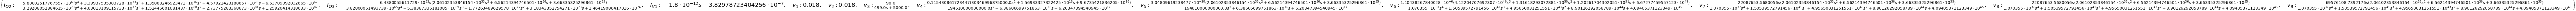

In [54]:
u1 = solve(equ,[v1, v2, v3, v4, v5, v6, v7, v8, v9, I_V1, I_O2, I_O3])
u1 # display the results

Node 9 is the output of the filter.

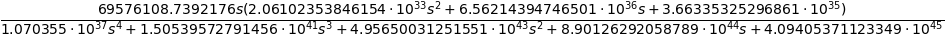

In [55]:
H = u1[v9]
H

Extract the numerator and denominator polynomials so that the system can be defined in SciPy.

In [56]:
num, denom = fraction(H) #returns numerator and denominator

# convert symbolic to numpy polynomial
a = np.array(Poly(num, s).all_coeffs(), dtype=float)
b = np.array(Poly(denom, s).all_coeffs(), dtype=float)
system_c1 = (a, b) # system for circuit 1

### Plot the impulse and step response
Use the SciPy functions [signal.impulse2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.impulse2.html) and [signal.step2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.step2.html) to plot the impulse and step response of the system.

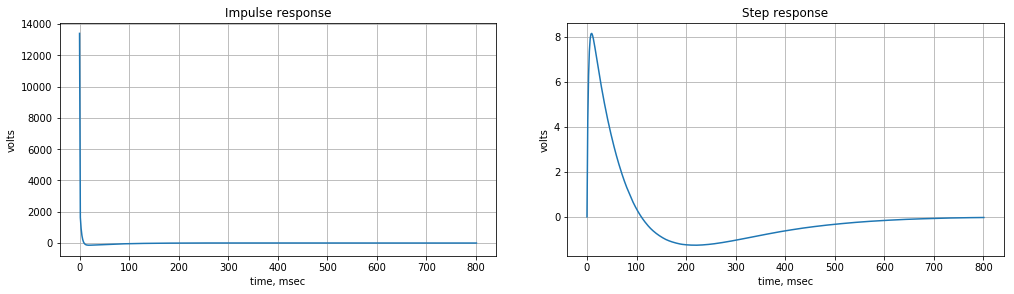

In [57]:
# figsize() function to adjust the size
plt.subplots(figsize=(15, 5))

# using subplot function and creating
# plot one
plt.subplot(1, 2, 1)

# impulse response
t, y = signal.impulse2(system_c1,N=500)
plt.plot(t/1e-3, y)
plt.title('Impulse response')
plt.ylabel('volts')
plt.xlabel('time, msec')
plt.grid()

# using subplot function and creating plot two
plt.subplot(1, 2, 2)

t, y = signal.step2(system_c1,N=500)
plt.plot(t/1e-3, y)
plt.title('Step response')
plt.ylabel('volts')
plt.xlabel('time, msec')
plt.grid()

# space between the plots
plt.tight_layout(4)

# show plot
plt.show()

The impulse and step response of the circuit is easliy generated by the SciPy functions signal.impulse2 and signal.step2 and plotted with the 
code above. The impulse response is not that interesting, but the step response shows that the circuit is a high pass filter and there is not to much ringing in the response. 

### Plot the Bode magnitude and phase data
Use the SciPy function [signal.bode](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.bode.html) to plot the magnitude and phase of the filter.

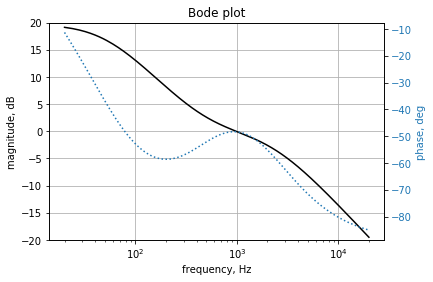

In [58]:
x = np.linspace(20*2*np.pi, 20e3*2*np.pi, 5000, endpoint=True)
w, mag, phase = signal.bode(system_c1, w=x)

fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

#plt.semilogx(w, mag)    # Bode magnitude plot
#plt.plot(w/(2*np.pi*1e6), mag,'-k')    # Bode magnitude plot
#plt.plot(w/(2*np.pi), mag,'-k')    # Bode magnitude plot
plt.semilogx(w/(2*np.pi), mag,'-k')    # Bode magnitude plot

ax1.tick_params(axis='y')
ax1.set_ylim((-20,20))
#ax1.set_xlim((27e6*2*np.pi,33e6*2*np.pi))
#ax1.set_xlim((27,33))
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'

#plt.semilogx(w, phase,'-g')  # Bode phase plot
#plt.plot(w/(2*np.pi), phase,':',color=color)  # Bode phase plot
plt.semilogx(w/(2*np.pi), phase,':',color=color)  # Bode phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim((-5,25))

plt.title('Bode plot')
plt.show()

The plot above agrees with the curves shown for RIAA. Setting the amplitude of V1 to 0.018 volts, puts the output of the filter at 0 dB at 1 KHz. This normalizes the Bode plot to agree with the application note. 

In [59]:
# gain margin
print('gain margin = {:.2f} dB'.format(mag[find_nearest(phase, -180)]))

gain margin = -19.49 dB


In [60]:
# phase margin
print('phase margin = {:.2f} deg'.format(phase[find_nearest(mag, -0.1 )] - (-180)))

phase margin = 131.57 deg


The code above calculates the gain and phase margin of the circuit. These two values are useful to determin the stability of a circuit. 

#### Plot the group delay.
The following python code calculates and plots [group delay](https://en.wikipedia.org/wiki/Group_delay_and_phase_delay#). Frequency components of a signal are delayed when passed through a circuit and the signal delay will be different for the various frequencies unless the circuit has the property of being linear phase. The delay variation means that signals consisting of multiple frequency components will suffer distortion because these components are not delayed by the same amount of time at the output of the device.

Group delay: $\tau _{g}(\omega )=-\frac  {d\phi (\omega )}{d\omega }$

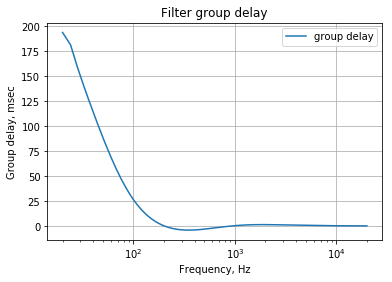

In [61]:
plt.title('Filter group delay')
plt.semilogx(w/(2*np.pi), -np.gradient(phase)/np.gradient(w)/1e-3,'-',label='group delay')
#plt.semilogx(w/(2*np.pi), -np.gradient(phase)/w/1e-3,'-',label='phase delay')
plt.ylabel('Group delay, msec')
plt.xlabel('Frequency, Hz')
plt.legend()
plt.grid()
plt.show()

The plot above shows that for frequencies below 200 Hz, there is a large amount of delay that is frequency dependent. Presumably, the delay compensates for the de-emphases introduced in the record cutting process.  

# Summary
Two OpAmp filter circuits were examined. The schematics for the circuits were drawn using LTspice and the netlist was exported as a text file. Modified nodal analysis code was run on the letlist to generate the nodal equations, which can then be solved symbolicaly or numericaly with either SymPy or SciPy. Starting with a schematic and then using this procedure eliminates errors that would occure if these circuits were analyised by hand. For small circuits with a handful of components, symbolic solutions of the node equations can be of interest, but for larger circuits, not so much. 

## Reference:
1. 3rd order LPF, 10.2, Handbook of Operational Amplifier Circuit Design, David F. Stout, McGraw-Hill 1976
2. [Analysis of the Sallen-Key Architecture](https://www.ti.com/lit/an/sloa024b/sloa024b.pdf), last accessed on 2 Sept 2022
3. AN-346 High-Performance Audio Applications of the LM833, May 2013, Texas Instruments Incorporated